In [ ]:
!pip install ultralytics
from ultralytics import YOLO

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
# Initiliaze working directories

# Change this to input folder
# Will look for all .MOV files, with code in the next section
KAGGLE_DATA_PATH = '/kaggle/input/include/Adjectives_1of8'

WORKING_DIR = '/kaggle/working/'
LANDMARKS_DIR = os.path.join(WORKING_DIR, 'extracted_landmarks')

# Use if cropping with Yolo
CROPPED_FRAMES_DIR = os.path.join(WORKING_DIR, 'yolo_cropped_frames')

os.makedirs(CROPPED_FRAMES_DIR, exist_ok=True)
os.makedirs(LANDMARKS_DIR, exist_ok=True)

# Create if not existant
print(f"Kaggle Data Path: {KAGGLE_DATA_PATH}")
print(f"Working Directory: {WORKING_DIR}")

model_name = "CNN_LSTM_v1"

Kaggle Data Path: /kaggle/input/include/Adjectives_1of8
Working Directory: /kaggle/working/


In [7]:
# Load all files relating to the input

file_paths = []

# This loop currently works for the INCLUDE Dataset
# Change this to make it fit your own dataset
for root, dirs, files in os.walk(KAGGLE_DATA_PATH):
    for file in files:
        if file.endswith('.MOV'):
            file_path = os.path.join(root, file)
            path_components = file_path.split('/')    
            for component in reversed(path_components):
                if '. ' in component:
                 word = component.split('. ')[1]
            file_paths.append([word.lower(), file_path])

In [8]:
# Additional/Private Dataset

KAGGLE_DATA_PATH_PRIVATE = "/kaggle/input/include-private/Adjectives_1of8"

for root, dirs, files in os.walk(KAGGLE_DATA_PATH_PRIVATE):
    for file in files:
        if file.endswith('.mp4'):
            file_path = os.path.join(root, file)
            path_components = file_path.split('/')    
            for component in reversed(path_components):
                if '. ' in component:
                 word = component.split('. ')[1]
            file_paths.append([word.lower(), file_path])

In [ ]:
# Creates an array in the form of ['word', 'file path']
file_paths = np.array(file_paths)
file_paths.shape

In [12]:
# Function to extract landmarks using MediaPipe Holistic Model
!pip install mediapipe
import mediapipe as mp

mp_holistic = mp.solutions.holistic

def extract_landmarks(frame, holistic_model, frame_number=None):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic_model.process(rgb_frame)

    expected_pose_size = 33 * 4
    expected_face_size = 468 * 3
    expected_hand_size = 21 * 3

    def get_landmarks_data(landmarks_obj, expected_size, include_visibility=False):
        if landmarks_obj:
            if include_visibility:
                data = np.array([[lmk.x, lmk.y, lmk.z, lmk.visibility] for lmk in landmarks_obj.landmark]).flatten()
            else:
                data = np.array([[lmk.x, lmk.y, lmk.z] for lmk in landmarks_obj.landmark]).flatten()
            return data
        return np.zeros(expected_size)

    # Get Landmarks
    pose_data = get_landmarks_data(results.pose_landmarks, expected_pose_size, include_visibility=True)
    face_data = get_landmarks_data(results.face_landmarks, expected_face_size)
    left_hand_data = get_landmarks_data(results.left_hand_landmarks, expected_hand_size)
    right_hand_data = get_landmarks_data(results.right_hand_landmarks, expected_hand_size)

    undetected_landmarks = []

    if results.pose_landmarks is None:
        undetected_landmarks.append("Pose")
    if results.face_landmarks is None:
        undetected_landmarks.append("Face")
    if results.left_hand_landmarks is None:
        undetected_landmarks.append("Left hand")
    if results.right_hand_landmarks is None:
        undetected_landmarks.append("Right hand")
    if undetected_landmarks:
        prefix = f"Frame {frame_number}: " if frame_number is not None else ""
        print(f"{prefix}Undetected landmarks: {', '.join(undetected_landmarks)}.")

    # Flattening the feature vectors to give single array of landmarks
    full_landmark_vector = np.concatenate([pose_data, face_data, left_hand_data, right_hand_data])
    
    return full_landmark_vector

# Function to loop through frames and create single np.array of features in shape of (number of videos, frames processed, features per frame)
# Saves the landmarks, and labels to a file in the working directory 
def process_videos(file_paths):
    holistic_model = mp_holistic.Holistic(
        static_image_mode=False, 
        model_complexity=2,
        min_detection_confidence=0.5, 
        min_tracking_confidence=0.5
    )

    video_landmarks = []
    labels = []

    # To generalize the videos
    SEQUENCE_LENGTH = 60
    
    for i, (word, file_path) in enumerate(file_paths):
        print(f"Processing video {i+1}/{len(file_paths)}: {file_path} for landmarks (word: {word})")
        
        cap = cv2.VideoCapture(file_path)
        if not cap.isOpened():
            print(f"Error: Could not open video file {file_path}. Skipping.")
            continue

        current_video_landmarks = []
        frame_count = 0  

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            landmarks_frame = extract_landmarks(frame, holistic_model, frame_count)
            if landmarks_frame is not None:
                current_video_landmarks.append(landmarks_frame)

            frame_count += 1

        cap.release()

        if not current_video_landmarks:
            print(f"No valid frames or landmarks extracted from {file_path}. Skipping video.")
            continue

        video_sequence_array = np.array(current_video_landmarks)

        # Pads or truncates the videos to specific size
        if video_sequence_array.shape[0] < SEQUENCE_LENGTH:
            padding_needed = SEQUENCE_LENGTH - video_sequence_array.shape[0]
            padded_sequence = np.pad(video_sequence_array, 
                                     ((0, padding_needed), (0, 0)), 
                                     mode='constant', constant_values=0)
            video_landmarks.append(padded_sequence)
        elif video_sequence_array.shape[0] > SEQUENCE_LENGTH:
            truncated_sequence = video_sequence_array[:SEQUENCE_LENGTH, :]
            video_landmarks.append(truncated_sequence)
        else:
            video_landmarks.append(video_sequence_array)
        
        labels.append(word)
                    
    video_landmarks = np.array(video_landmarks)
    labels = np.array(labels)

    np.save(os.path.join(LANDMARKS_DIR, 'pose_landmarks_landmarks.npy'), video_landmarks)
    np.save(os.path.join(LANDMARKS_DIR, 'pose_landmarks_labels.npy'), labels)

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)

    print(f"\nSaved {video_landmarks.shape[0]} sequences and labels to {LANDMARKS_DIR}")
    print(f"Shape of extracted sequences (X): {video_landmarks.shape}")
    print(f"Shape of encoded labels (y): {y_encoded.shape}")

    holistic_model.close()

In [13]:
process_videos(file_paths)

Processing video 1/144: /kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_9290.MOV for landmarks (word: loud)


W0000 00:00:1751314039.487297     154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751314039.674665     154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751314039.678389     153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751314039.678506     151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751314039.678658     152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751314039.695471     152 inference_feedback_manager.cc:114] Feedback manager 

Frame 11: Undetected landmarks: Right hand.
Frame 12: Undetected landmarks: Right hand.
Frame 13: Undetected landmarks: Right hand.
Frame 14: Undetected landmarks: Left hand, Right hand.
Frame 15: Undetected landmarks: Left hand, Right hand.
Frame 16: Undetected landmarks: Left hand, Right hand.
Frame 17: Undetected landmarks: Left hand, Right hand.
Frame 18: Undetected landmarks: Left hand.
Frame 45: Undetected landmarks: Left hand.
Frame 46: Undetected landmarks: Left hand, Right hand.
Frame 47: Undetected landmarks: Left hand, Right hand.
Frame 48: Undetected landmarks: Left hand, Right hand.
Frame 49: Undetected landmarks: Left hand, Right hand.
Frame 50: Undetected landmarks: Left hand, Right hand.
Frame 51: Undetected landmarks: Left hand.
Frame 52: Undetected landmarks: Left hand.
Processing video 2/144: /kaggle/input/include/Adjectives_1of8/Adjectives/1. loud/MVI_5258.MOV for landmarks (word: loud)
Frame 0: Undetected landmarks: Left hand.
Frame 9: Undetected landmarks: Right h

In [14]:
# Load the landmarks from working directory

X = np.load(os.path.join(LANDMARKS_DIR, 'pose_landmarks_landmarks.npy'))
y = np.load(os.path.join(LANDMARKS_DIR, 'pose_landmarks_labels.npy'))

In [4]:
# Load the landmarks from an uploaded file

X = np.load("/kaggle/input/landmarks-extracted/pose_landmarks_landmarks.npy")
y = np.load("/kaggle/input/landmarks-extracted/pose_landmarks_labels.npy")

In [5]:
# Check if loaded correctly
print("Landmarks preview: \n", X[0])
print("Landmarks array shape: \n", X.shape)
print("Labels array shape: \n", y.shape)

Landmarks preview: 
 [[ 0.48630583  0.35479909 -0.52718693 ...  0.41376522  1.00503421
   0.0080107 ]
 [ 0.48621017  0.35488755 -0.52777106 ...  0.40040633  0.99176592
   0.01896957]
 [ 0.48612928  0.35488304 -0.53528559 ...  0.41364419  1.00260413
   0.00648379]
 ...
 [ 0.48132306  0.35261399 -0.5267334  ...  0.38702124  0.97029626
   0.01263577]
 [ 0.48132119  0.35275587 -0.54307491 ...  0.38727611  0.9713316
   0.01174397]
 [ 0.4813233   0.35286936 -0.52748704 ...  0.38933939  0.97365218
   0.01501061]]
Landmarks array shape: 
 (144, 60, 1662)
Labels array shape: 
 (144,)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit label encoder on the labels and transform them
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Now, y_train_encoded and y_test_encoded should be arrays of integers
categories = label_encoder.classes_

# Print the categories
print("Encoded Categories:")
print(categories)

Encoded Categories:
['beautiful' 'blind' 'deaf' 'happy' 'loud' 'quiet' 'sad' 'ugly']


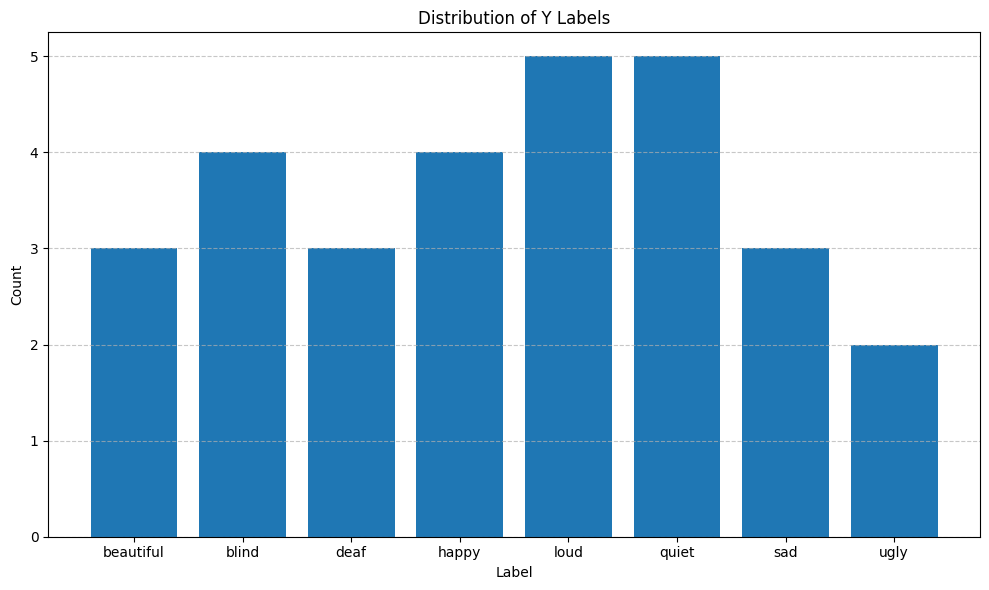

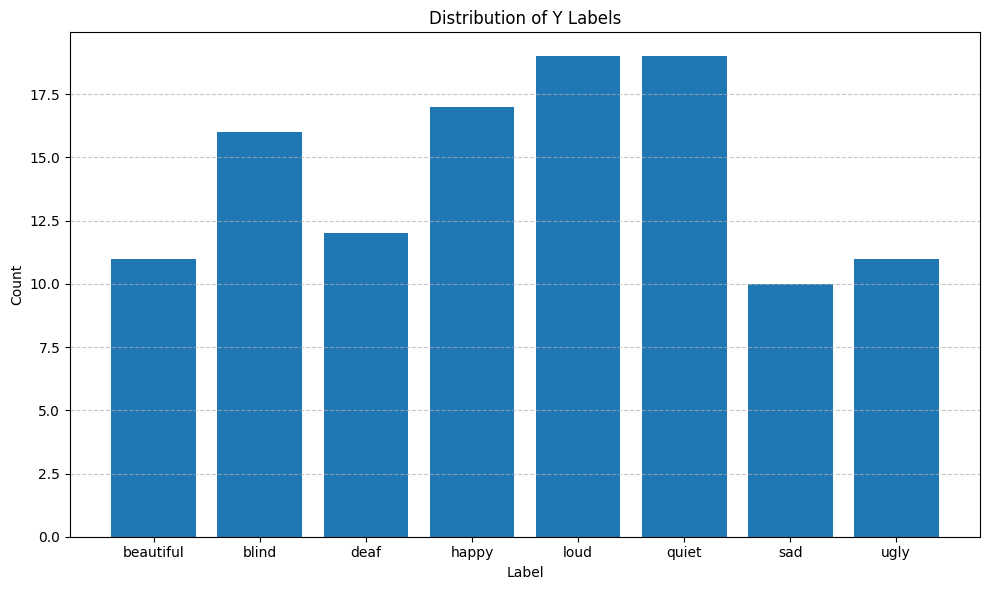

In [22]:
# See the distribution of test, and training data

unique_labels, counts = np.unique(y_test, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, tick_label=unique_labels)
plt.title('Distribution of Y Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

unique_labels, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, tick_label=unique_labels)
plt.title('Distribution of Y Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
# Augument to data to increase dataset size

def add_noise(sequence, noise_level=0.01):
    noise = np.random.normal(loc=0.0, scale=noise_level, size=sequence.shape)
    return sequence + noise

def scale_sequence(sequence, scale_range=(0.8, 1.2)):
    scale_factor = np.random.uniform(scale_range[0], scale_range[1])
    return sequence * scale_factor

def random_crop_sequence(sequence, desired_length=60):
    current_length = sequence.shape[0]
    if current_length > desired_length:
        start_frame = np.random.randint(0, current_length - desired_length)
        return sequence[start_frame:start_frame + desired_length]
    elif current_length < desired_length:
        padding_needed = desired_length - current_length
        last_frame = np.expand_dims(sequence[-1], axis=0)
        padding = np.repeat(last_frame, padding_needed, axis=0)
        return np.vstack([sequence, padding])
    else:
        return sequence

def flip_landmarks(sequence, original_landmark_dim=1662):
    flipped_sequence = sequence.copy()
    
    for frame in flipped_sequence:
        x_indices = np.arange(0, original_landmark_dim, 3)
        frame[x_indices] = -frame[x_indices]
    
    return flipped_sequence

def augment_dataset(X, y, num_augmentations_per_sample=3):
    augmented_X = []
    augmented_y = []
    
    total_original_samples = len(X)
    
    for i in range(total_original_samples):
        original_sequence = X[i]
        original_label = y[i]
        
        augmented_X.append(original_sequence)
        augmented_y.append(original_label)
        
        for _ in range(num_augmentations_per_sample):
            augmented_sequence = original_sequence.copy()
            
            if random.random() < 0.7:
                augmented_sequence = add_noise(augmented_sequence, noise_level=0.005)
            
            if random.random() < 0.5:
                augmented_sequence = scale_sequence(augmented_sequence, scale_range=(0.9, 1.1))
            
            if random.random() < 0.5:
                augmented_sequence = random_crop_sequence(augmented_sequence, desired_length=60)
                
            if random.random() < 0.5:
                augmented_sequence = flip_landmarks(augmented_sequence, original_landmark_dim=1662)

            augmented_X.append(augmented_sequence)
            augmented_y.append(original_label)
            
    augmented_X = np.array(augmented_X)
    augmented_y = np.array(augmented_y)
    
    shuffled_indices = np.arange(len(augmented_X))
    np.random.shuffle(shuffled_indices)
    augmented_X = augmented_X[shuffled_indices]
    augmented_y = augmented_y[shuffled_indices]
    
    return augmented_X, augmented_y

x_train_augmented, y_train_augmented = augment_dataset(x_train, y_train_encoded, num_augmentations_per_sample=5)

print(f"Original training data shape: {x_train.shape}")
print(f"Original training labels shape: {y_train.shape}")
print("-" * 30)
print(f"Augmented training data shape: {x_train_augmented.shape}")
print(f"Augmented training labels shape: {y_train_augmented.shape}")

Original training data shape: (115, 60, 1662)
Original training labels shape: (115,)
------------------------------
Augmented training data shape: (690, 60, 1662)
Augmented training labels shape: (690,)


In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.layers import Reshape
from keras.optimizers import Adam
import tensorflow as tf

num_classes = len(np.unique(y_train_encoded))

In [11]:
model = Sequential()
model.add(TimeDistributed(Reshape((x_train.shape[2], 1)), input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu')))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5)) 
model.add(LSTM(64)) 
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1751367920.043525      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751367920.044185      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
history = model.fit(x_train_augmented, y_train_augmented, validation_data=(x_test, y_test_encoded), epochs=220, batch_size=4, shuffle=True)

loss, accuracy = model.evaluate(x_test, y_test_encoded)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Epoch 1/220


I0000 00:00:1751367965.539445      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


173/173 ━━━━━━━━━━━━━━━━━━━━ 44s 166ms/step - accuracy: 0.1236 - loss: 2.1024 - val_accuracy: 0.1379 - val_loss: 2.0806
Epoch 2/220
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.2348 - loss: 2.0096 - val_accuracy: 0.1379 - val_loss: 2.1125
Epoch 3/220
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 144ms/step - accuracy: 0.2345 - loss: 1.9773 - val_accuracy: 0.1379 - val_loss: 2.1037
Epoch 4/220
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step - accuracy: 0.3076 - loss: 1.8987 - val_accuracy: 0.1724 - val_loss: 2.1518
Epoch 5/220
 34/173 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.3173 - loss: 1.8595

Keys in the history dictionary: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Loss and accuracy plots have been saved as 'loss_plot.png' and 'accuracy_plot.png'.


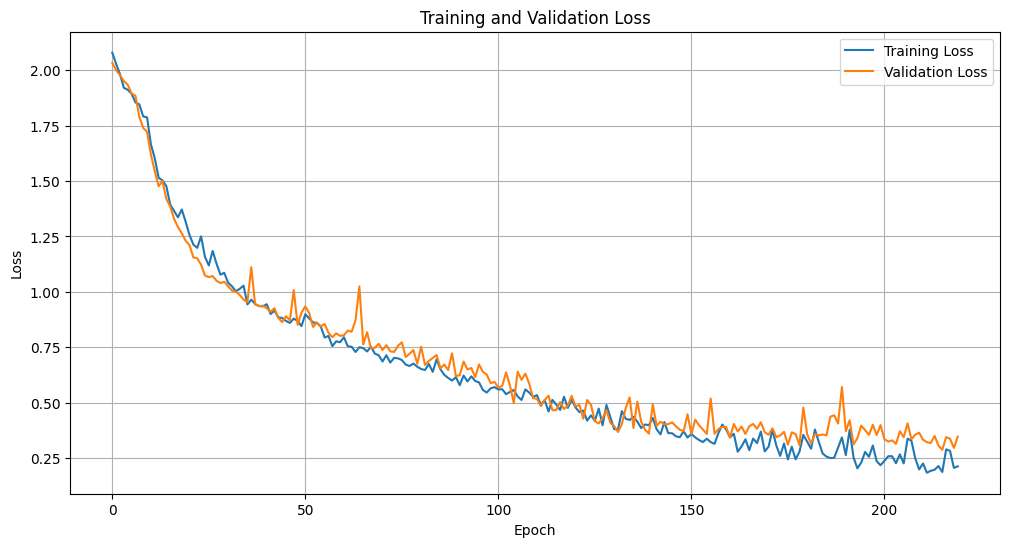

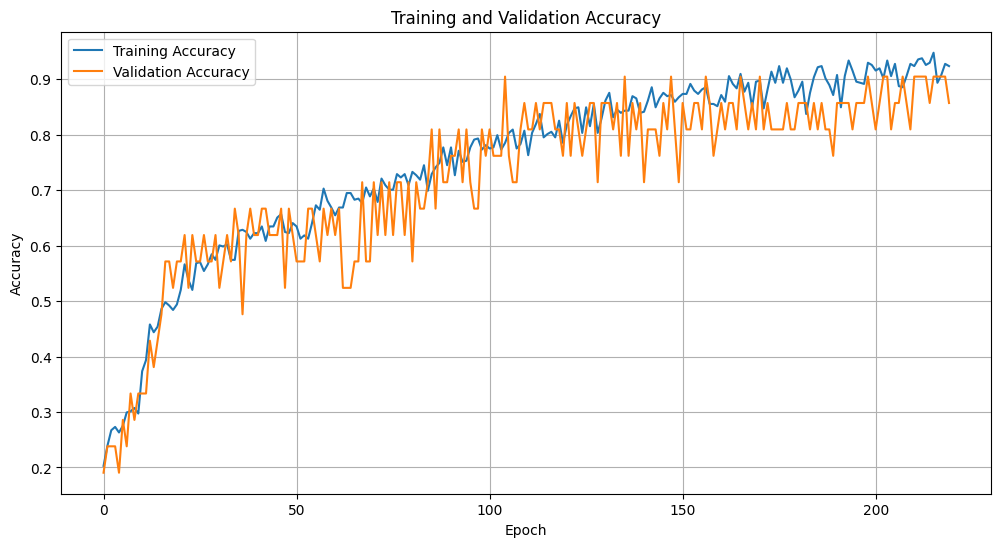

In [22]:
history_dict = history.history
print("Keys in the history dictionary:", history_dict.keys())

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png')

print("Loss and accuracy plots have been saved as 'loss_plot.png' and 'accuracy_plot.png'.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


<Figure size 1000x800 with 0 Axes>

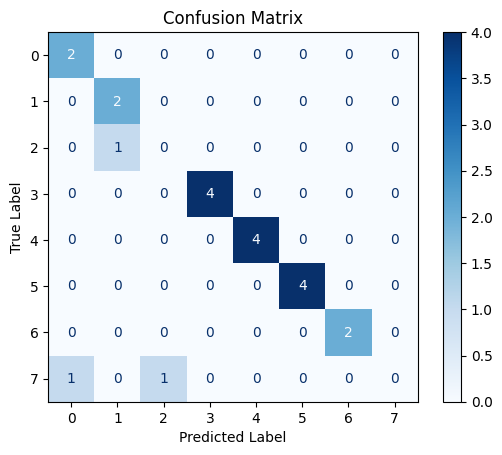

Confusion matrix plot has been saved as 'confusion_matrix.png'.


In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict(x_test)

# Convert the model's one-hot encoded predictions to integer labels.
y_pred_classes = np.argmax(y_pred, axis=1)

# y_test_encoded is already a 1D array of integer labels, so use it directly.
y_true_classes = y_test_encoded

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

class_labels = None # Or provide your list of class names

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')
plt.show()

print("Confusion matrix plot has been saved as 'confusion_matrix.png'.")

In [7]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    hp_kernel_size = hp.Int('conv1d_kernel_size', min_value=3, max_value=9, step=2)
    
    hp_filters = hp.Int('conv1d_filters', min_value=32, max_value=128, step=32)
    
    hp_pool_size = hp.Int('maxpool1d_pool_size', min_value=2, max_value=4, step=1)
    
    hp_lstm1_units = hp.Int('lstm1_units', min_value=64, max_value=256, step=64)
    hp_lstm2_units = hp.Int('lstm2_units', min_value=32, max_value=128, step=32)

    hp_dropout1_rate = hp.Float('dropout1_rate', min_value=0.2, max_value=0.6, step=0.1)
    hp_dropout2_rate = hp.Float('dropout2_rate', min_value=0.2, max_value=0.5, step=0.1)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # --- Model Architecture ---
    model.add(TimeDistributed(Reshape((x_train.shape[2], 1)), input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(TimeDistributed(Conv1D(filters=hp_filters, kernel_size=hp_kernel_size, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=hp_pool_size)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(hp_lstm1_units, return_sequences=True))
    model.add(Dropout(hp_dropout1_rate))
    model.add(LSTM(hp_lstm2_units))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(hp_dropout2_rate))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [9]:
tuner = kt.Hyperband(
    build_model,          # The model-building function
    objective='val_accuracy', # The metric to optimize (maximize validation accuracy)
    max_epochs=50,        # Max epochs for each trial
    factor=3,             # Hyperband reduction factor
    hyperband_iterations=5, # Number of times to run the hyperband algorithm
    directory='my_dir',   # Directory to store the search results
    project_name='cnn_lstm_hyperband_tuning'
)

print("Starting the hyper parameter search...")
tuner.search(x_train_augmented, y_train_augmented,
                 epochs=100,
                 validation_data=(x_test, y_test_encoded),
                 batch_size=4)

print("Hyperparameter search is complete!")

Trial 22 Complete [00h 00m 43s]

Best val_accuracy So Far: 0.17241379618644714
Total elapsed time: 00h 38m 38s

Search: Running Trial #23

Value             |Best Value So Far |Hyperparameter
7                 |7                 |conv1d_kernel_size
96                |64                |conv1d_filters
2                 |2                 |maxpool1d_pool_size
128               |64                |lstm1_units
64                |96                |lstm2_units
0.5               |0.2               |dropout1_rate
0.2               |0.2               |dropout2_rate
0.01              |0.01              |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ke

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/execute.py", line 59, in quick_execute
    except TypeError as e:
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/sequential_1/time_distributed_2_1/strided_slice_12/StridedSliceGrad defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_35/4162965633.py", line 12, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 234, in search

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 77, in train_step

OOM when allocating tensor with shape[60,4,1656,96] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_1/time_distributed_2_1/strided_slice_12/StridedSliceGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_412588]


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The best hyperparameters found are:
- Conv1D Kernel Size: {best_hps.get('conv1d_kernel_size')}
- Conv1D Filters: {best_hps.get('conv1d_filters')}
- MaxPooling1D Pool Size: {best_hps.get('maxpool1d_pool_size')}
- LSTM 1 Units: {best_hps.get('lstm1_units')}
- LSTM 2 Units: {best_hps.get('lstm2_units')}
- Dropout 1 Rate: {best_hps.get('dropout1_rate')}
- Dropout 2 Rate: {best_hps.get('dropout2_rate')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model for a longer period
print("Training the best model on the full dataset...")
history = best_model.fit(x_train_augmented, y_train_augmented,
                          validation_data=(x_test, y_test_encoded),
                          epochs=300, # Use more epochs for the final training
                          batch_size=2)

# Evaluate the final model
loss, accuracy = best_model.evaluate(x_test, y_test_encoded)
print(f"Final Test Accuracy: {accuracy*100:.2f}%")

# You can also save the final model
best_model.save('best_cnn_lstm_model.h5')

In [ ]:
# Save the model on disk
best_model.save(f"{model_name}.h5")

In [ ]:
import zipfile
zip = zipfile.ZipFile(f"{model_name}.zip", "w", zipfile.ZIP_DEFLATED)
zip.write(f"/kaggle/working/{model_name}.h5")
zip.close()

In [7]:
# Uploading to google drive if file is too big for kaggle direct download
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Upload the files
uploaded = drive.CreateFile({'title': f"{model_name}_best.zip", 'mimeType': 'application/zip'})
uploaded.SetContentFile(f"/kaggle/working/{model_name}.h5")
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))